# Olympic Rings Experiment

In [1]:
import scipy
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.mixture
import sklearn.neighbors 
from sklearn.datasets import make_moons, make_circles
from sklearn.preprocessing import KernelCenterer
from sklearn.metrics import confusion_matrix
sns.set(style="darkgrid")

from sample_distributions import pair_sample_mixture_of_GMs, sample_olympic_rings
from NDIGO import NDIGO, gauss_kernal_mat, gen_ZG, gen_C, clustNP_obj, proj_simplex

# Set Parameters

In [2]:
np.random.seed(0) #reproducibility

n = 1000 # number of total paired samples
nhold = 200
ntest = 200
M = 5   # true number of mixture components for our KDE
d = 2   # ambient dimension 

# Generate Rings Data

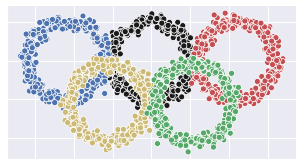

In [3]:
#Generate Data
noise_sd = 0.1
X, component_ids, pair_ids = sample_olympic_rings(n, noise_sd=noise_sd, rand_state=0)
Xh, cid_h, pid_h = sample_olympic_rings(nhold, noise_sd=noise_sd, rand_state=111)
Xte, cid_te, pid_te = sample_olympic_rings(ntest, noise_sd=noise_sd, rand_state=99)

#plot the data and look at moons
dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": component_ids[:,], "true_class": component_ids[:,]})
dfh = pd.DataFrame({"x": Xh[:,0], "y": Xh[:,1], "decisions": cid_h[:,], "true_class": cid_h[:,]})

#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['k', 'r', 'b', 'y', 'g'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')

# Visualize Paired Samples

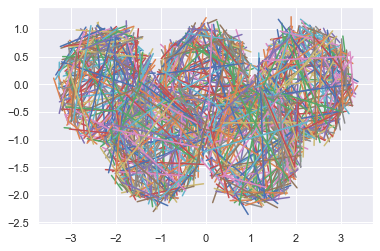

In [4]:
#Plot the line segment connecting the members of each pair
for i in range(n):
    pair = X[pair_ids==i]
    plt.plot(pair[:,0], pair[:,1])

# NDIGO

# Optimization

### Initialize Parameters

In [5]:
Rs = [50,60,70,80,90,100]
best_ISE = 1e10;
d = X.shape[1]

# do a line search on sigma to find the best eigenvector initialization
for R in Rs:
    sd = np.min(np.std(X, axis=0))
    sigmas = [sd*(2*n)**(-1/(d+4))]
    Z, _ = gen_ZG(X, R, 1)

    for sigma in sigmas:
        _, G = gen_ZG(X, R, sigma, Z=Z)
        C = gen_C(X, pair_ids, Z, R, sigma)
        w, A = scipy.sparse.linalg.eigs(G, k=M)
        w = np.real(w)
        A = np.real(A)
        for i in range(M):
                A[:,i] = proj_simplex(A[:,i])
        w = w/np.sum(w)
        A = A / np.sum(A,axis=0)
        f, _ = clustNP_obj(A, w, G, C, n, 0)
        print(sigma, R, f)
        if f < best_ISE:
            best_ISE = f
            best_sigma = sigma
            best_R = R
            best_w = w
            best_Z = Z
            best_C = C
            best_G = G
            best_A = A
print(best_sigma, best_R, best_ISE)       

0.25130374141037365 50 0.030537270058221586
0.25130374141037365 60 0.02464003137686202
0.25130374141037365 70 0.03423936696685061
0.25130374141037365 80 0.03802483453651681
0.25130374141037365 90 0.06969952584126793
0.25130374141037365 100 0.07809302010512072
0.25130374141037365 60 0.02464003137686202


### Optimize

In [6]:
# Parameters
sigma = best_sigma
R = best_R
w0 = best_w
Z = best_Z
C = best_C
G = best_G
A0 = best_A
ss=10

# TISE of initialization
print(best_ISE)

# solve
f_star, A_star, w_star, Z, n_iter = NDIGO(X, pair_ids.astype("int"), A0, w0, Z, G, stepsize=ss, ss_decr=1, 
                                            epoch_decr = 40, method='psgd', max_iter=100, f_tol=1e-16, 
                                            sigma=sigma, batch_size=64, decay=0.01, momentum=0.2)
# TISE of solution
print(f_star)

0.02464003137686202
-0.00010919148133474487



# Plot NDIGO Density Estimate

(-3.6, 3.599999999999999, -2.5, 1.5)

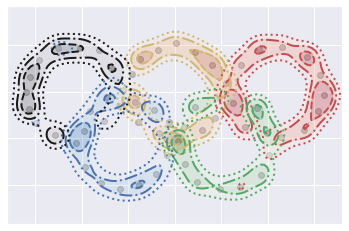

In [7]:
xmin, xmax = -3.6, 3.6
ymin, ymax = -2.5, 1.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])

#construct kde based on discretization and learned weights

#class 0
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[0]*A_star[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 1
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[1]*A_star[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 2
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[2]*A_star[:,2]).clip(1e-16))
f2 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 3
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[3]*A_star[:,3]).clip(1e-16))
f3 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))

#class 4
kde = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde.fit(Z, y=None, sample_weight=(w_star[4]*A_star[:,4]).clip(1e-16))
f4 = np.exp(np.reshape(kde.score_samples(positions.T).T, xx.shape))


# plot kernel centers
plt.scatter(x=Z[:,0], y=Z[:,1], color="black", alpha = 0.2)

# Values for level set curves
levels = [0.1, 0.15, 0.2, 0.3]


CSb = plt.contourf(xx, yy, f0, levels, cmap="Reds", alpha=sigma)
CSb2 = plt.contour(xx, yy, f0, levels,
                  colors=('r',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSb.cmap.set_over('r')

CSg = plt.contourf(xx, yy, f3, levels, cmap="Oranges", alpha=sigma)
CSg2 = plt.contour(xx, yy, f3, levels,
                  colors=('y',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSg.cmap.set_over('y')

CSk = plt.contourf(xx, yy, f4, levels, cmap="Greens", alpha=sigma)
CSk2 = plt.contour(xx, yy, f4, levels,
                  colors=('g',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSk.cmap.set_over('g')

CSo = plt.contourf(xx, yy, f2, levels, cmap="Blues", alpha=sigma)
CSo2 = plt.contour(xx, yy, f2, levels,
                  colors=('b',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSo.cmap.set_over('b')

CSr = plt.contourf(xx, yy, f1, levels, cmap="Greys", alpha=sigma)
CSr2 = plt.contour(xx, yy, f1, levels,
                  colors=('k',),
                  linewidths=(2,),
                  linestyles=(':', '-.', '--', '-' ),
                  origin="lower",
                  extend='max')
CSr.cmap.set_over('k')

plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axis('equal')

# Predict

accuracy: 0.9019999999999999, adjusted rand index: 0.7841524331659232


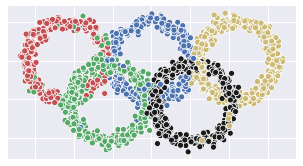

In [8]:
#make predictions
phats_train = np.zeros((X.shape[0], M))
phats_te = np.zeros((Xte.shape[0], M))
for i in range(X.shape[0]):
    kx = gauss_kernal_mat(X[i, np.newaxis], Z, sigma)
    phats_train[i, :] = kx@A_star
for i in range(Xh.shape[0]):
    kxte = gauss_kernal_mat(Xte[i,np.newaxis], Z, sigma)
    phats_te[i, :] = kxte@A_star
ltr = np.zeros((X.shape[0], M))
lte = np.zeros((Xte.shape[0], M))
for i in set(pair_ids):
    ltr[pair_ids==i, :] = np.tile(w_star.T*np.prod(phats_train[pair_ids==i,np.newaxis], axis=0), (2,1))
lte = w_star.T*phats_te
decisions_train = np.argmax(ltr, 1)
decisions_te = np.argmax(lte, 1)

#plot data and decisions
dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": decisions_train[:,], "true_class": component_ids[:,]},)
dfte = pd.DataFrame({"x": Xte[:,0], "y": Xte[:,1], "decisions": decisions_te[:,], "true_class": cid_te[:,]})

sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['y', 'r', 'g', 'b', 'k'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')

#compute best accuracy of clustering
cm = sklearn.metrics.confusion_matrix(component_ids, decisions_train, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
        
ARI = sklearn.metrics.adjusted_rand_score(component_ids, decisions_train)
print(f"accuracy: {acc}, adjusted rand index: {ARI}")

# Spectral Clustering

In [9]:
import sklearn.cluster
spclust = sklearn.cluster.SpectralClustering(n_clusters=M)
spclust.fit(X)

SpectralClustering(n_clusters=5)

accuracy: 0.6025, adjusted rand index: 0.24516932242124287


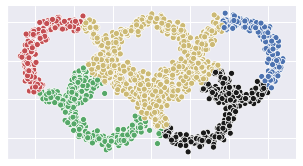

In [10]:
#np.sum(spclust.labels_)
#spclust.affinity_matrix_
dftr = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": spclust.labels_, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=['g', 'k', 'b', 'r', 'y'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')

#compute best accuracy of clustering
cm = sklearn.metrics.confusion_matrix(component_ids, spclust.labels_, normalize='all')
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(component_ids, spclust.labels_)
print(f"accuracy: {acc}, adjusted rand index: {ARI}")

# Constrained Spectral Clustering

In [11]:
from clustering_methods import constr_spec_clust

connectivity = np.zeros((2*n, 2*n))
for i in range(n):
    i, j = tuple(np.nonzero(pair_ids==i)[0])
    connectivity[i,j] = 1
    connectivity[j,i] = 1
Q = connectivity
A = spclust.affinity_matrix_
beta = 1
u_star, labels, _ = constr_spec_clust(A, Q, beta=beta, n_clust=M)

accuracy: 0.5805, adjusted rand index: 0.3161193174428016


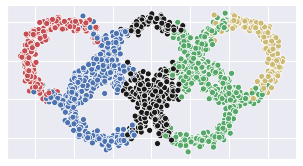

In [12]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['y', 'k', 'b', 'g', 'r'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')

#compute best accuracy of clustering
cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(component_ids, labels)
print(f"accuracy: {acc}, adjusted rand index: {ARI}")

# NPMIX

In [13]:
from NPMIX import NPMIX
labels, ofit_gmm, gmm_assn = NPMIX(X, M=M, M_over=2*M)

accuracy: 0.481, adjusted rand index: 0.0835577008879824


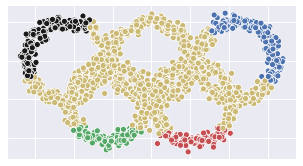

In [14]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['y', 'r', 'k', 'g', 'b'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')

#compute best accuracy of clustering
cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(component_ids, labels)
print(f"accuracy: {acc}, adjusted rand index: {ARI}")

# Constrained GMM

In [15]:
from constr_gmm import constr_gmm
M=5
constr_gmm = constr_gmm(X,pair_ids,M,50,0)     
constr_gmm.run()
labels= np.argmax(constr_gmm.predict(X), axis=1)

accuracy: 0.4825, adjusted rand index: 0.21831991656095562


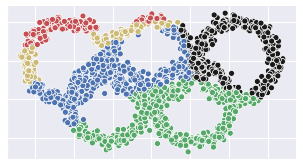

In [16]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['y', 'r', 'k', 'g', 'b'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal')

#compute best accuracy of clustering

cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(component_ids, labels)        
print(f"accuracy: {acc}, adjusted rand index: {ARI}")

# MV-LVM

In [17]:
X1, cid1, pid1 = sample_olympic_rings(n//3, noise_sd=noise_sd, rand_state=0)
X2, cid2, pid2 = sample_olympic_rings(n//3, noise_sd=noise_sd, rand_state=111)
X3, cid3, pid3 = sample_olympic_rings(n//3, noise_sd=noise_sd, rand_state=222)

In [18]:
from clustering_methods import MVLVM
sd = np.min(np.std(X, axis=0))
sigma = sd*(2*n)**(-1/(d+4))
A, w = MVLVM(X1,X2,X3,k=5,sigma=0.5*sigma, n_iter=100)
Xa = np.vstack((X1,X2))

In [19]:
import sklearn.neighbors 

xmin, xmax = -3.6, 3.6
ymin, ymax = -2.5, 1.5
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
#construct kde based on discretization and learned weights
#evaluate on grid of points

#class 0
kde0 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde0.fit(Xa, y=None, sample_weight=(A[:,0]).clip(1e-16))
f0 = np.exp(np.reshape(kde0.score_samples(positions.T).T, xx.shape))

#class 1
kde1 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde1.fit(Xa, y=None, sample_weight=(A[:,1]).clip(1e-16))
f1 = np.exp(np.reshape(kde1.score_samples(positions.T).T, xx.shape))

#class 2
kde2 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde2.fit(Xa, y=None, sample_weight=(A[:,2]).clip(1e-16))
f2 = np.exp(np.reshape(kde2.score_samples(positions.T).T, xx.shape))

#class 3
kde3 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde3.fit(Xa, y=None, sample_weight=(A[:,3]).clip(1e-16))
f3 = np.exp(np.reshape(kde3.score_samples(positions.T).T, xx.shape))

#class 4
kde4 = sklearn.neighbors.KernelDensity(bandwidth=sigma);
kde4.fit(Xa, y=None, sample_weight=(A[:,4]).clip(1e-16))
f4 = np.exp(np.reshape(kde4.score_samples(positions.T).T, xx.shape))

accuracy: 0.7626865671641792, adjusted rand index: 0.5499284364782029


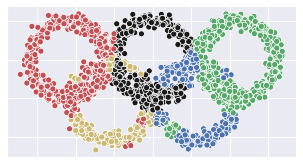

In [20]:
#make predictions
vals_tr = np.zeros((X1.shape[0] + X2.shape[0] + X3.shape[0],M))
vals_tr[:,0] = kde0.score_samples(np.vstack((X1,X2,X3)))
vals_tr[:,1] = kde1.score_samples(np.vstack((X1,X2,X3)))
vals_tr[:,2] = kde2.score_samples(np.vstack((X1,X2,X3)))
vals_tr[:,3] = kde3.score_samples(np.vstack((X1,X2,X3)))
vals_tr[:,4] = kde4.score_samples(np.vstack((X1,X2,X3)))
labels = np.argmax(vals_tr, 1)
vals_te = np.zeros((Xte.shape[0],M))

dftr = pd.DataFrame({"x": np.hstack((X1[:,0], X2[:,0],X3[:,0])), "y": np.hstack((X1[:,1], X2[:,1],X3[:,1])), "decisions": labels[:,], "true_class": np.hstack((cid1,cid2,cid3)).T})

#plot data and decisions
sns.relplot(x ="x", y="y", data=dftr, hue="decisions", palette=["y", "g", 'k', 'b', 'r'], legend=False)
plt.xlabel("")
plt.ylabel("")
ax = plt.gca()
ax.set_aspect('equal')
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])

#compute best accuracy of clustering
cm = sklearn.metrics.confusion_matrix(np.hstack((cid1, cid2, cid3)), labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(np.hstack((cid1, cid2, cid3)), labels)        
print(f"accuracy: {acc}, adjusted rand index: {ARI}")

# GMM

In [21]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=M)
labels = gmm.fit_predict(X)

accuracy: 0.4235, adjusted rand index: 0.2103090230604102


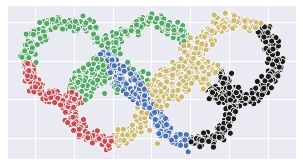

In [22]:
df = pd.DataFrame({"x": X[:,0], "y": X[:,1], "decisions": labels, "true_class": component_ids})
#plot data and decisions
sns.relplot(x ="x", y="y", data=df, hue="decisions", palette=['y', 'r', 'k', 'g', 'b'], legend=False)
ax = plt.gca()
plt.xlabel("")
plt.ylabel("")
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.set_aspect('equal', 'box')

#compute best accuracy of clustering
cm = sklearn.metrics.confusion_matrix(component_ids, labels, normalize='all')
import itertools
perms = np.array(tuple((itertools.permutations(range(cm.shape[0])))))
acc = 0
for perm in range(perms.shape[0]):
    tr = np.trace(cm[perms[perm,:],:])
    if tr > acc:
        acc = tr
ARI = sklearn.metrics.adjusted_rand_score(component_ids, labels)        
print(f"accuracy: {acc}, adjusted rand index: {ARI}")